### Generic code:

Developed below are some simple functions to retrieve all the images in a directory as a list and a function to convert a function into gray scale.

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import os
import pandas as pd
import seaborn as sns

def getimagelist(dir):    
    img_list = []
    for file in os.listdir(dir):
        if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
            img_list.append(file)
    return img_list
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

### Gray Histogram

In [ ]:
def getgrayhist(im):
    im_arr = rgb2gray(np.array(im))
    gray_hist = np.zeros((256,1))
    for i in range(0,im_arr.shape[0]):
        for j in range(0,im_arr.shape[1]):
            gray_hist[int(im_arr[i,j])] += 1
    gray_hist = gray_hist/im_arr.size
    return gray_hist

### Smoothness of the histogram:

In [ ]:
def getsmoothness(hist):
    smoothness = 0;
    for i in range(len(hist)-1):
        smoothness += np.absolute(hist[i]-hist[i+1])
    return smoothness

### Training the model : 

In [ ]:
natural_dir = '/Users/vikas/PycharmProjects/ECEN662/ImageProject/TrainingSetScenes'
synthetic_dir = '/Users/vikas/PycharmProjects/ECEN662/ImageProject/TrainingSetSynthetic'
natural_list = getimagelist(natural_dir)
synthetic_list = getimagelist(synthetic_dir)


size = np.minimum(len(natural_list),len(synthetic_list))
# Natural Images
natural_smoothness = np.zeros((size,1))
for i in range(size):
    scene = natural_list[i]
    img = Image.open(os.path.join(natural_dir, scene))
    img = img.resize((256, 256), Image.ANTIALIAS)
    hist = getgrayhist(img)
    natural_smoothness[i] = getsmoothness(hist)
    img.close()
    
# Synthetic Image
synthetic_smoothness = np.zeros((size,1))
for i in range(size):
    cgi = synthetic_list[i]
    img = Image.open(os.path.join(synthetic_dir, cgi))
    img = img.resize((256, 256), Image.ANTIALIAS)
    hist = getgrayhist(img)
    synthetic_smoothness[i] = getsmoothness(hist)
    img.close() 
    
smoothness = {'Natural': natural_smoothness[0:size-1,0],
              'Synthetic':synthetic_smoothness[0:size-1,0]}

sm_df = pd.DataFrame(smoothness)
sm_df.to_csv('HistSmoothResult.csv')

### Distribution of the feature:

In [ ]:
train_df = pd.read_csv('HistSmoothResult.csv')
natural_list = np.array(train_df.Natural.values)
synthetic_list = np.array(train_df.Synthetic.values)

mu = [np.mean(natural_list),np.mean(synthetic_list)]
var = [np.var(natural_list), np.var(synthetic_list)]

# sns.distplot(natural_list, label='Natural')
# sns.distplot(synthetic_list, label='Synthetic')
# plt.legend()
# plt.show()

### Decision Rule:

In [ ]:
def executedecisionrule(test_path):
    test_list = getimagelist(test_path)
    res_list = []
    smt_list = []
    thr = 0.22
    for test in test_list:
        
        test_img = Image.open(os.path.join(test_path, test))
        hist = getgrayhist(test_img)
        sm = getsmoothness(hist)
        smt_list.append(sm)
        
        # threshold test
        res = 1 if sm>(thr) else 0
        res_list.append(res)
        test_img.close()
        
    return [res_list,smt_list]

### Performance:

In [ ]:
natural_dir = '/Users/vikas/PycharmProjects/ECEN662/ImageProject/Natural'
synthetic_dir = '/Users/vikas/PycharmProjects/ECEN662/ImageProject/Synthetic'
[nat_res, nat_smt] = executedecisionrule(natural_dir)
[syn_res, syn_smt] = executedecisionrule(synthetic_dir)

In [ ]:
np.mean(nat_res) # Probability of false alarm.

In [ ]:
np.mean(syn_res) # Probability of detection.

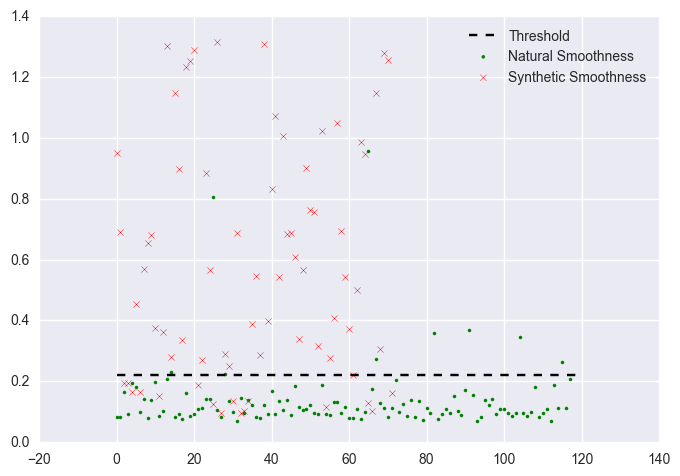

In [10]:
y = np.arange(120)
plt.scatter(np.arange(len(nat_smt)),nat_smt, marker='.', color='g', label='Natural Smoothness')
plt.scatter(np.arange(len(syn_smt)),syn_smt, marker='x', color='r', label='Synthetic Smoothness')
thr = [0.22 for i in y]
plt.plot(y,thr,'k--', label='Threshold')
plt.legend()
plt.show()